In [6]:
#To run xT program new version of socceraction action has to be used 
!pip install socceraction --upgrade

  Using cached socceraction-1.3.0-py3-none-any.whl (86 kB)
  Attempting uninstall: socceraction
    Found existing installation: socceraction 0.2.0
    Uninstalling socceraction-0.2.0:
      Successfully uninstalled socceraction-0.2.0



[notice] A new release of pip available: 22.2.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [8]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

In [9]:
import os
import tqdm
import pandas as pd
import numpy as np

In [10]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.xthreat as xthreat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

In [12]:
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [14]:
selected_competitions = selected_competitions1[selected_competitions1.season_name == "2018"]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
19,3,43,FIFA World Cup,International,male,2018


In [15]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,781,795,2018-06-22 14:00:00,2,0
1,774,783,2018-06-15 14:00:00,0,1
2,791,794,2018-06-23 17:00:00,1,2
3,783,799,2018-06-20 17:00:00,1,0
4,782,798,2018-06-18 17:00:00,3,0
...,...,...,...,...,...
59,796,774,2018-06-19 20:00:00,3,1
60,796,785,2018-07-07 20:00:00,2,2
61,776,771,2018-06-26 16:00:00,0,0
62,778,787,2018-06-24 17:00:00,2,2


In [16]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|███████████████████████████████████████████████████████████████| 64/64 [02:59<00:00,  2.81s/it]


In [17]:
datafolder = "../data-fifa"

In [18]:
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

In [19]:
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [45]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,8657,a7ec7898-799e-4e79-bc54-54d4cba812cf,1,0.0,782,3289.0,52.941176,33.569620,44.117647,33.569620,0,1,5,0,pass,success,foot_right,Romelu Lukaku,Belgium
1,8657,f6046ebb-23b5-4ca2-ad94-f6428e1dd073,1,1.0,782,5642.0,44.117647,33.569620,44.117647,34.430380,21,1,0,1,dribble,success,foot,Axel Witsel,Belgium
2,8657,ff0b59e3-4c63-48cf-a81d-024dd69e1c95,1,2.0,782,5642.0,44.117647,34.430380,31.764706,53.367089,0,1,5,2,pass,success,foot_right,Axel Witsel,Belgium
3,8657,6133b1ef-1489-4851-9eef-b1d66f898461,1,3.0,782,3077.0,31.764706,53.367089,28.235294,53.367089,21,1,0,3,dribble,success,foot,Jan Vertonghen,Belgium
4,8657,9c0d9486-4c63-4d5d-bb31-4e2a06c5a486,1,4.0,782,3077.0,28.235294,53.367089,23.823529,38.734177,0,1,4,4,pass,success,foot_left,Jan Vertonghen,Belgium


In [46]:
xT_h5 = os.path.join(datafolder, "xT.h5")

In [47]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

nb of games: 64


In [48]:
A = []

with pd.HDFStore(spadl_h5) as spadlstore:
    for game in tqdm.tqdm(list(games.itertuples())):
        actions = (spadlstore[f"actions/game_{8657}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )
        actions = spadl.play_left_to_right(actions, game.home_team_id)
        A.append(actions) 

A = pd.concat(A)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 13.51it/s]


In [49]:
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

In [50]:
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A);

# iterations:  75


In [97]:
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.rate(mov_actions)

In [98]:
def round_two_places(val):
    return round(val, 4)
# Apply the rounding function to the 'Values' column
mov_actions['xT_value'] = mov_actions['xT_value'].apply(round_two_places)

In [99]:
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,52.058824,34.430380,60.882353,34.430380,-0.0026
1,dribble,60.882353,34.430380,60.882353,33.569620,-0.0019
2,pass,60.882353,33.569620,73.235294,14.632911,-0.0006
3,dribble,73.235294,14.632911,76.764706,14.632911,0.0000
4,pass,76.764706,14.632911,81.176471,29.265823,-0.0004
5,dribble,81.176471,29.265823,87.352941,37.012658,0.0004
6,pass,87.352941,37.012658,86.470588,61.974684,0.0004
7,dribble,86.470588,61.974684,61.764706,64.556962,0.0012
8,pass,61.764706,64.556962,56.470588,66.278481,0.0007
9,dribble,56.470588,66.278481,57.352941,66.278481,0.0000


In [100]:
mov_actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,nickname,team_name,xT_value
0,8657,a7ec7898-799e-4e79-bc54-54d4cba812cf,1,0.0,782,3289.0,52.058824,34.430380,60.882353,34.430380,0,1,5,0,pass,success,foot_right,Romelu Lukaku Menama,Romelu Lukaku,Belgium,-0.0026
1,8657,f6046ebb-23b5-4ca2-ad94-f6428e1dd073,1,1.0,782,5642.0,60.882353,34.430380,60.882353,33.569620,21,1,0,1,dribble,success,foot,Axel Witsel,None,Belgium,-0.0019
2,8657,ff0b59e3-4c63-48cf-a81d-024dd69e1c95,1,2.0,782,5642.0,60.882353,33.569620,73.235294,14.632911,0,1,5,2,pass,success,foot_right,Axel Witsel,None,Belgium,-0.0006
3,8657,6133b1ef-1489-4851-9eef-b1d66f898461,1,3.0,782,3077.0,73.235294,14.632911,76.764706,14.632911,21,1,0,3,dribble,success,foot,Jan Vertonghen,None,Belgium,0.0000
4,8657,9c0d9486-4c63-4d5d-bb31-4e2a06c5a486,1,4.0,782,3077.0,76.764706,14.632911,81.176471,29.265823,0,1,4,4,pass,success,foot_left,Jan Vertonghen,None,Belgium,-0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,8657,b5c3fe63-55a9-4401-8707-2f57e2ba4dc2,2,2846.0,782,3089.0,30.882353,10.329114,28.235294,1.721519,0,1,5,2503,pass,success,foot_right,Kevin De Bruyne,None,Belgium,0.0018
2504,8657,a4049086-b6a4-4545-a916-5d0e5e8b7388,2,2847.0,782,3077.0,28.235294,1.721519,28.235294,1.721519,21,1,0,2504,dribble,success,foot,Jan Vertonghen,None,Belgium,0.0000
2505,8657,88fb2cf5-4b26-4792-8f9c-2b7f87079be5,2,2848.0,782,3077.0,28.235294,1.721519,25.588235,1.721519,0,1,5,2505,pass,success,foot_right,Jan Vertonghen,None,Belgium,0.0059
2509,8657,378def7a-deb9-4af7-a691-d8d51913dabc,2,2861.0,768,3308.0,11.470588,3.443038,9.705882,2.582278,21,1,0,2509,dribble,success,foot,Kieran Trippier,None,England,0.0000


In [101]:
shot =4055
a = mov_actions[shot-3:shot+1].copy()
a

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,nickname,team_name,xT_value
2197,8657,0bbbdb95-2d60-4856-85e6-b1f8137f8822,2,2179.0,782,5642.0,67.941176,23.240506,51.176471,19.797468,0,1,5,2197,pass,success,foot_right,Axel Witsel,None,Belgium,0.0032
2198,8657,d6860afe-e6b6-494e-87e9-68e3ad08da7c,2,2181.0,782,3089.0,51.176471,19.797468,34.411765,25.822785,21,1,0,2198,dribble,success,foot,Kevin De Bruyne,None,Belgium,0.0044
2199,8657,79fa1bf5-5402-4eb7-8ed0-62752b27bc44,2,2184.0,782,3089.0,34.411765,25.822785,17.647059,18.936709,0,1,5,2199,pass,success,foot_right,Kevin De Bruyne,None,Belgium,0.0302
2200,8657,328b9d77-4fbf-43cb-9b93-198645c71be8,2,2185.0,782,3621.0,17.647059,18.936709,7.058824,29.265823,21,1,0,2200,dribble,success,foot,Eden Hazard,None,Belgium,0.1967


In [102]:
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

In [103]:
a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name", "xT_value"]]

In [104]:
import matplotsoccer

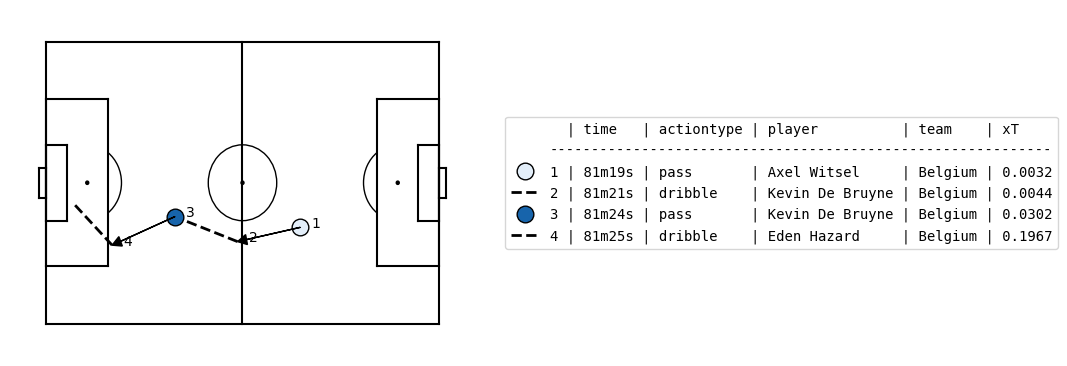

In [105]:
ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team","xT"],
    zoom=False,
    figsize=6
)


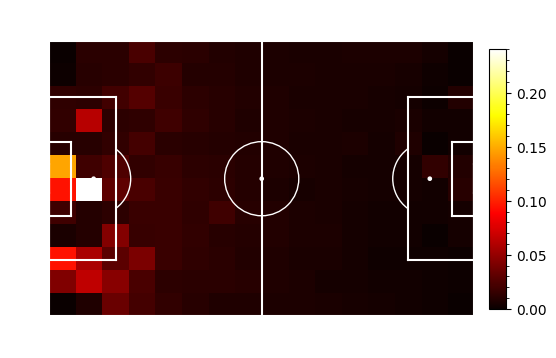

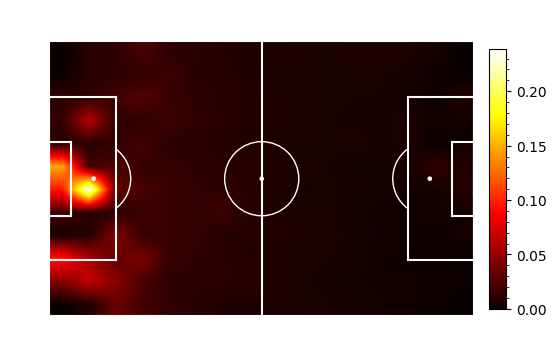

<AxesSubplot:>

In [114]:
import matplotsoccer as mps

# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

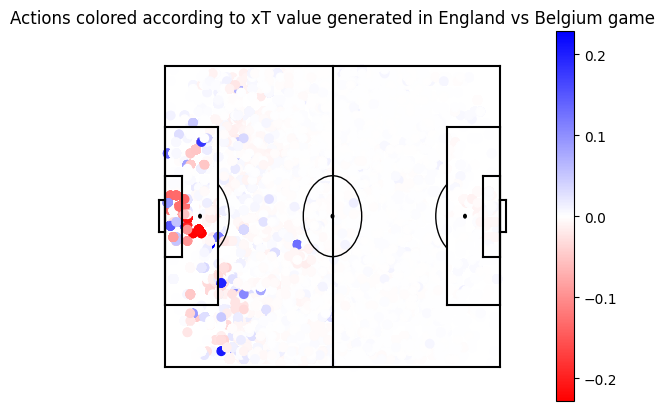

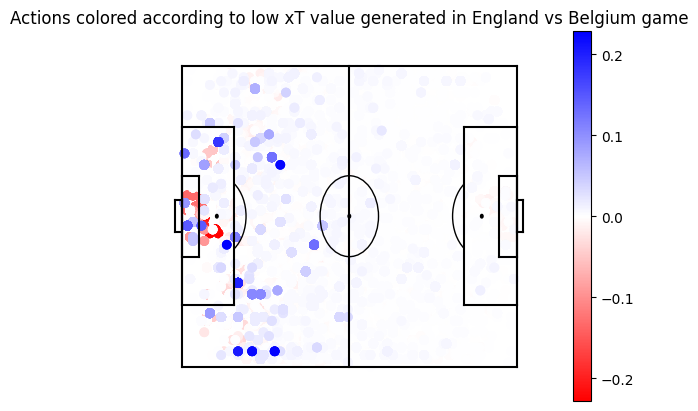

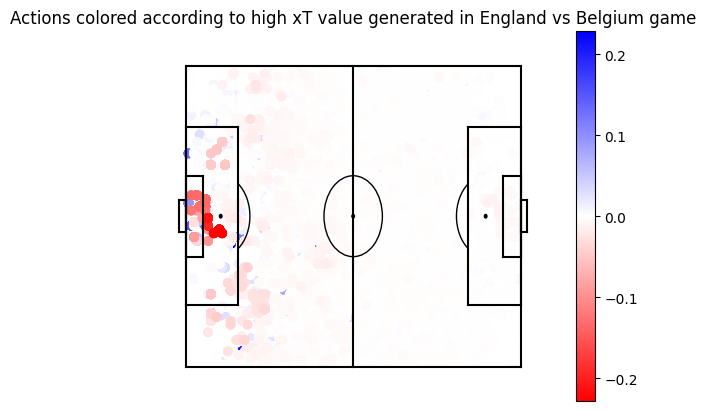

In [115]:
import matplotlib.pyplot as plt

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value generated in England vs Belgium game")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.title("Actions colored according to low xT value generated in England vs Belgium game")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.title("Actions colored according to high xT value generated in England vs Belgium game")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()